<a href="https://colab.research.google.com/github/lipiecki/energy-analytics-2025/blob/main/notebooks/Averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast averaging

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### Load one of the included datasets - EPEX or GEFCom

In [2]:
dataset = "epex" # "epex" or "gefcom"
url = f"https://raw.githubusercontent.com/lipiecki/energy-analytics-2025/refs/heads/main/data/{dataset}.csv"
local = f"../data/{dataset}.csv"

In [3]:
df = pd.read_csv(url, delimiter=',', header=0, index_col=[0, 1])
df.head()

price   load_da  load_real  day_of_week
date     hour                                         
20220101 0     50.05  41989.50   43915.50            6
         1     41.33  40105.50   41535.75            6
         2     43.22  38784.00   40480.75            6
         3     45.46  37751.00   39564.00            6
         4     37.67  37877.25   39338.25            6

### Prepare the explenatory variables for the regression models

In [4]:
# create lag columns for prices from previous days
df['lag1'] = df['price'].shift(24)  # price one day ago (24 hours)
df['lag2'] = df['price'].shift(48)  # price two days ago (48 hours)
df['lag7'] = df['price'].shift(168) # price seven days ago (168 hours)
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20220108 0     164.17  51093.00   52694.75            6  128.92   99.85   
         1     152.83  49105.50   50532.50            6  118.40  101.32   
         2     166.00  48075.25   49608.25            6  103.01  110.01   
         3     160.86  47763.50   49543.25            6  101.91  111.55   
         4     160.00  47900.25   49077.25            6  101.98  123.37   
...               ...       ...        ...          ...     ...     ...   
20241231 19    200.00  56083.25   54868.50            2  165.93  206.72   
         20    204.61  53423.00   51940.50            2  184.44  194.97   
         21    186.25  50937.50   50559.50            2  203.88  195.95   
         22    146.52  47657.50   49133.50            2  168.46  167.31   
         23    141.68  45257.25   49607.50            2  162.92  149.98   

                 lag7  
date     hour          
20220108 0      50.05  
         1      41.33  
         2      43.22  
         3      45.46  
         4      37.67  
...               ...  
20241231 19    105.66  
         20    102.56  
         21     94.63  
         22     99.04  
         23     90.00  

[26136 rows x 7 columns]

### Define the lengths of the training window


In [ ]:
windows = list(range(56, 365*2, 28))

### Select explanatory variables for the model
And cast the data to an array format

In [ ]:
X = np.array(df[['lag1', 'lag2', 'lag7', 'load_da']])
Y = np.array(df['price'])

### Generate forecasts using linear regression
AutoRegressive with eXogenuous variables (ARX)

In [6]:
for window in windows:
  df[f'arx{window}_forecast'] = np.nan
  for i in range(max(windows)*24, len(df)):
     # prepare training data
      X_window = X[i-window*24:i:24, :]
      Y_window = Y[i-window*24:i:24]

      # fit the model to training data
      arx = LinearRegression()
      arx = arx.fit(X_window, Y_window)

      # prepare inputs for the next day and hour
      X_next = X[[i], :]

      # predict
      df.iloc[i, df.columns.get_loc(f'arx{window}_forecast')] = arx.predict(X_next)

### Remove days without forecasts and average the forecasts

In [7]:
df.dropna(inplace=True)
df['arx_ave_forecast'] = df[[f"arx{window}_forecast" for window in windows]].mean(axis=1)
df['arx_ave2_forecast'] = df[[f"arx{window}_forecast" for window in (windows[:3] + windows[-3:])]].mean(axis=1)

### Plot the RMSE for every training window and the averages

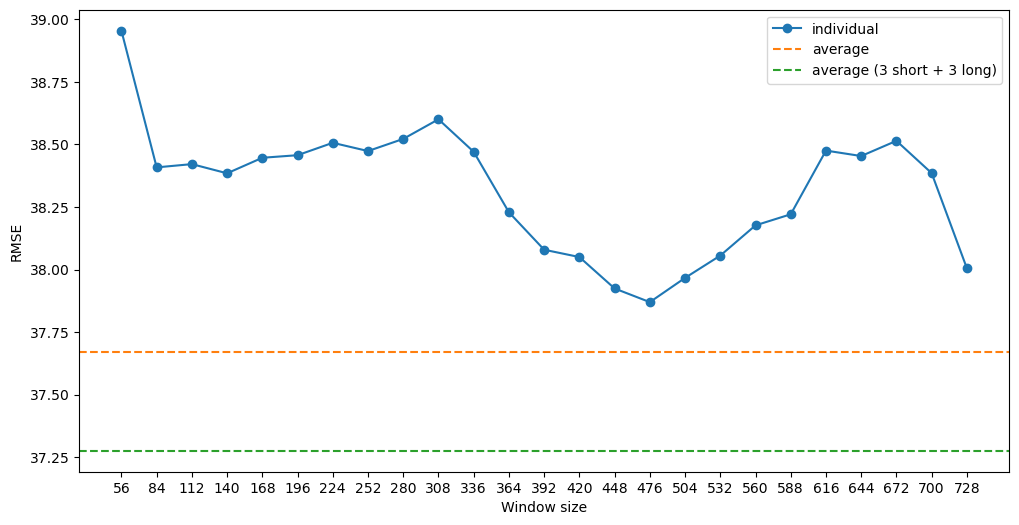

In [8]:
plt.figure(figsize=(12, 6))
rmse = [np.sqrt(mean_squared_error(df['price'], df[f'arx{window}_forecast'])) for window in windows]
plt.plot(windows, rmse, '-o', label="individual")
plt.axhline(np.sqrt(mean_squared_error(df['price'], df['arx_ave_forecast'])), color='C1', linestyle='--', label="average")
plt.axhline(np.sqrt(mean_squared_error(df['price'], df['arx_ave2_forecast'])), color='C2', linestyle='--', label="average (3 short + 3 long)")
plt.xticks(windows)
plt.xlabel("Window size")
plt.ylabel("RMSE")
plt.legend()

### Plot the MAE for every training window and the averages

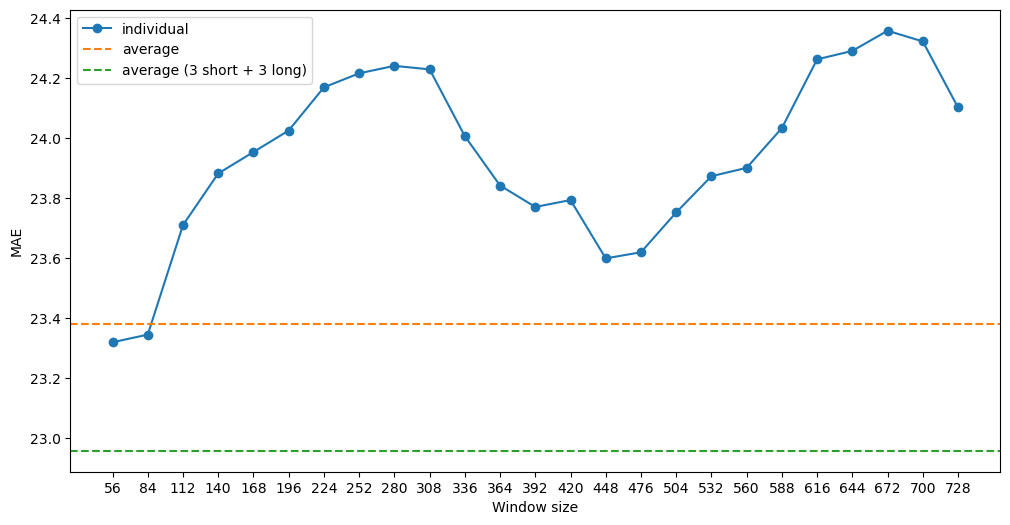

In [9]:
plt.figure(figsize=(12, 6))
rmse = [(mean_absolute_error(df['price'], df[f'arx{window}_forecast'])) for window in windows]
plt.plot(windows, rmse, '-o', label="individual")
plt.axhline((mean_absolute_error(df['price'], df['arx_ave_forecast'])), color='C1', linestyle='--', label="average")
plt.axhline((mean_absolute_error(df['price'], df['arx_ave2_forecast'])), color='C2', linestyle='--', label="average (3 short + 3 long)")
plt.xticks(windows)
plt.xlabel("Window size")
plt.xlabel("Window size")
plt.ylabel("MAE")
plt.legend()